# Thermography

## Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay, classification_report
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalMaxPooling2D, Dropout, Dense, Lambda, Input
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg16

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


## Data selection

In [3]:
class Data:
	def __init__(self, root):
		self.table = self.__generate_table(root)
		self.training, self.validation, self.test = None, None, None

	def __generate_table(self, root):
		files = []

		for category in os.listdir(root):
			for filename in os.listdir(root + category):
				files.append([root + category + "/" + filename, category])

		return pd.DataFrame(files, columns=["filename", "category"])

In [4]:
class parameters:
	width = 150
	height = 150
	epochs = 200
	batch_size = 20

In [5]:
data = Data("./data/thermography/")

In [6]:
data.table.head(1)

filename category
0  ./data/thermography/healthy/16-TFRON_V16_31-10...  healthy

## Preprocessing and transformation

In [7]:
data.table.category = data.table.category.factorize()[0].astype(str)

In [8]:
data.table.head(1)

filename category
0  ./data/thermography/healthy/16-TFRON_V16_31-10...        0

In [9]:
data.training, data.test = train_test_split(data.table, test_size=0.15, shuffle=True)

In [10]:
print(f"Raw: {data.table.category.value_counts().values}")
print(f"Training: {data.training.category.value_counts().values}")
print(f"Test: {data.test.category.value_counts().values}")

Raw: [99 96]
Training: [84 81]
Test: [15 15]


In [11]:
train_datagen = image.ImageDataGenerator(
	rescale=1./255,
	validation_split=0.2
)

test_datagen = image.ImageDataGenerator(
    rescale=1./255
)

In [12]:
train_generator = train_datagen.flow_from_dataframe(
	dataframe=data.training,
    x_col="filename",
    y_col="category",
    target_size=(parameters.height, parameters.width),
    batch_size=parameters.batch_size,
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb",
    subset="training"
)

validation_generator = train_datagen.flow_from_dataframe(
	dataframe=data.training,
    x_col="filename",
    y_col="category",
    target_size=(parameters.height, parameters.width),
    batch_size=parameters.batch_size,
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb",
    subset="validation"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data.test,
    x_col="filename",
    y_col="category",
    target_size=(parameters.height, parameters.width),
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    color_mode="rgb",
)

Found 132 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


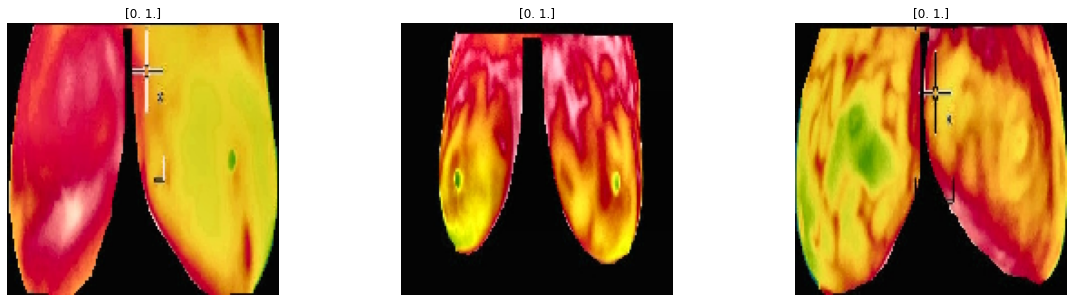

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

img, label = train_generator.next()

for i in range(3):    
    ax[i].imshow(img[i])
    ax[i].title.set_text(str(label[i]))
    ax[i].axis("off")
    
plt.show()

## Data mining

### Model creation

In [14]:
base_model = vgg16.VGG16(
	include_top=False,
	weights="imagenet",
	input_tensor=Input(shape=(parameters.height, parameters.width, 3))
)

head_model = base_model.output

head_model = GlobalMaxPooling2D() (head_model)
head_model = Dropout(0.4) (head_model)
head_model = Dense(32, activation="relu") (head_model)
head_model = Dropout(0.4) (head_model)
head_model = Dense(2, activation="softmax") (head_model)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
	layer.trainable = False

model.summary()

58900480/58889256 [==============================] - 209s 4us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________________

In [15]:
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=1e-3, decay=(1e-3)/parameters.epochs), metrics=["accuracy"])

In [16]:
# plot_model(model, show_shapes=True)

In [17]:
with open("./model.json", "w") as json_file:
	json_file.write(model.to_json())

In [18]:
model_path = "weight.hdf5"

checkpoint = ModelCheckpoint(model_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

### Model training

In [19]:
history = model.fit(
	train_generator,
	steps_per_epoch=train_generator.samples // train_generator.batch_size,
	epochs=parameters.epochs,
	validation_data=validation_generator,
	validation_steps=validation_generator.samples // validation_generator.batch_size,
	callbacks=[checkpoint]
)

Epoch 1/200
6/6 [==============================] - 17s 2s/step - loss: 0.9648 - accuracy: 0.4821 - val_loss: 0.6714 - val_accuracy: 0.6500

Epoch 00001: val_accuracy improved from -inf to 0.65000, saving model to weight.hdf5
Epoch 2/200
6/6 [==============================] - 2s 324ms/step - loss: 0.8592 - accuracy: 0.5357 - val_loss: 0.6620 - val_accuracy: 0.6000

Epoch 00002: val_accuracy did not improve from 0.65000
Epoch 3/200
6/6 [==============================] - 2s 347ms/step - loss: 0.6995 - accuracy: 0.6250 - val_loss: 0.6477 - val_accuracy: 0.7000

Epoch 00003: val_accuracy improved from 0.65000 to 0.70000, saving model to weight.hdf5
Epoch 4/200
6/6 [==============================] - 2s 324ms/step - loss: 0.6778 - accuracy: 0.6250 - val_loss: 0.6296 - val_accuracy: 0.7000

Epoch 00004: val_accuracy did not improve from 0.70000
Epoch 5/200
6/6 [==============================] - 2s 326ms/step - loss: 0.6633 - accuracy: 0.6339 - val_loss: 0.6126 - val_accuracy: 0.7500

Epoch 000

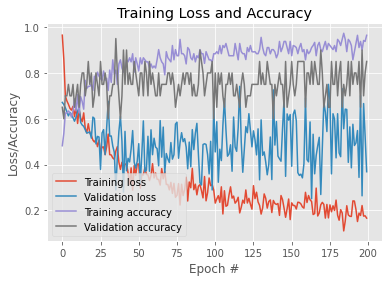

In [20]:
plt.style.use("ggplot")

plt.figure()

plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()

### Model evaluation

In [21]:
model.load_weights(model_path)

In [22]:
def evaluateModel(predict, evaluate=False):
	model.evaluate(predict)

	if evaluate:
		predictions = np.argmax(model.predict(predict), axis=-1)

		cm = confusion_matrix(predict.classes, predictions)
		display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(predict.labels))
		display = display.plot(cmap=plt.cm.Blues, xticks_rotation=0)
		plt.show()

		print(classification_report(predict.classes, predictions))

		TP = cm[1][1]
		TN = cm[0][0]
		FP = cm[0][1]
		FN = cm[1][0]

		accuracy = (float(TP + TN) / float(TP + TN + FP + FN))
		print("Accuracy:", round(accuracy, 4))

		specificity = (TN / float(TN + FP))
		print("Specificity:", round(specificity, 4))

		sensitivity = (TP / float(TP + FN))
		print("Sensitivity:", round(sensitivity, 4))

		precision = (TP / float(TP + FP))
		print("Precision:", round(precision, 4))

7/7 [==============================] - 2s 260ms/step - loss: 0.3100 - accuracy: 0.8864


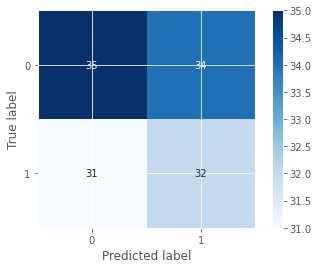

              precision    recall  f1-score   support

           0       0.53      0.51      0.52        69
           1       0.48      0.51      0.50        63

    accuracy                           0.51       132
   macro avg       0.51      0.51      0.51       132
weighted avg       0.51      0.51      0.51       132

Accuracy: 0.5076
Specificity: 0.5072
Sensitivity: 0.5079
Precision: 0.4848


In [23]:
evaluateModel(train_generator, True)

2/2 [==============================] - 6s 6s/step - loss: 0.4725 - accuracy: 0.7576


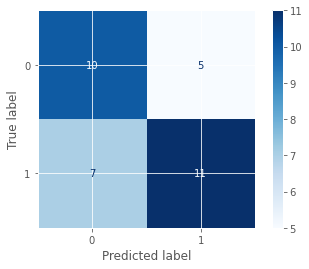

              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.69      0.61      0.65        18

    accuracy                           0.64        33
   macro avg       0.64      0.64      0.64        33
weighted avg       0.64      0.64      0.64        33

Accuracy: 0.6364
Specificity: 0.6667
Sensitivity: 0.6111
Precision: 0.6875


In [24]:
evaluateModel(validation_generator, True)

30/30 [==============================] - 3s 46ms/step - loss: 0.5910 - accuracy: 0.7000


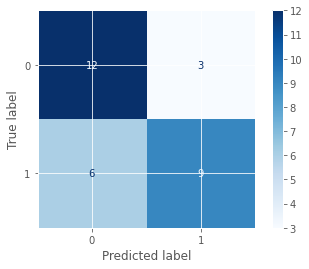

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        15
           1       0.75      0.60      0.67        15

    accuracy                           0.70        30
   macro avg       0.71      0.70      0.70        30
weighted avg       0.71      0.70      0.70        30

Accuracy: 0.7
Specificity: 0.8
Sensitivity: 0.6
Precision: 0.75


In [25]:
evaluateModel(test_generator, True)

In [26]:
def get_gradcam_heatmap(path, model, prediction_index=None):
	for idx in range(len(model.layers)):
		if (idx == 2):
			conv_output_name = model.get_layer(index=idx).name

	grad_model = Model([model.input], [model.get_layer(conv_output_name).output, model.output])

	with tf.GradientTape() as tape:
		conv_output, predictions = grad_model(path)

		if prediction_index is None:
			prediction_index = np.argmax(predictions[0])

		class_channel = predictions[:, 1]

	grads = tape.gradient(class_channel, conv_output)
	pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

	conv_output = conv_output[0]
	
	heatmap = conv_output @ pooled_grads[..., tf.newaxis]
	heatmap = tf.squeeze(heatmap)
	heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

	return heatmap.numpy()

def save_gradcam(path, heatmap, title):
	img = image.load_img(path, color_mode="grayscale")
	img = image.img_to_array(img)

	heatmap = np.uint8(255 * heatmap)
	jet = cm.get_cmap("jet")
	jet_colors = jet(np.arange(256))[:, :3]
	jet_heatmap = jet_colors[heatmap]
	jet_heatmap = image.array_to_img(jet_heatmap)
	jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
	jet_heatmap = image.img_to_array(jet_heatmap)

	superimposed_img = jet_heatmap * 0.4 + img
	superimposed_img = image.array_to_img(superimposed_img)

	fig, ax = plt.subplots(1, 3, figsize=(20, 8))

	ax[0].imshow(cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB))
	ax[1].imshow(superimposed_img)
	ax[2].imshow(image.array_to_img(jet_heatmap))

	fig.suptitle(title)
	plt.subplots_adjust(top=1.3)

	if not os.path.isdir("results/"):
		os.makedirs("results/")

	plt.savefig("results/" + os.path.basename(path), bbox_inches="tight")
	
	plt.show()

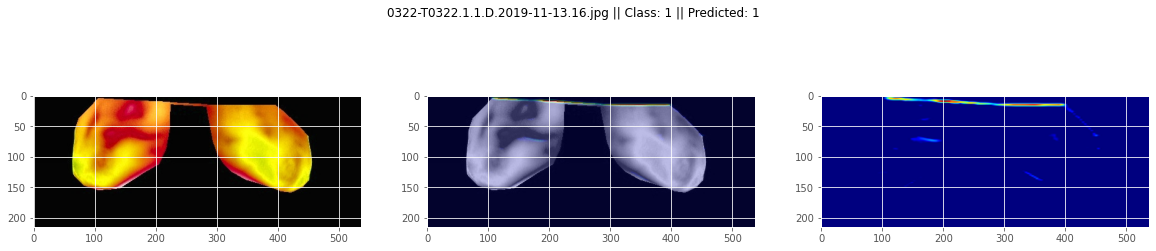

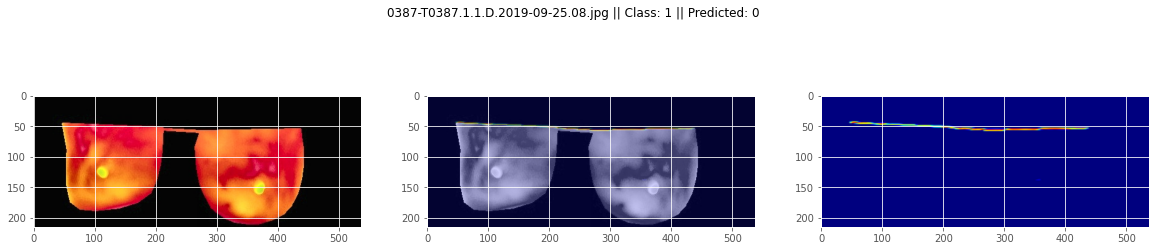

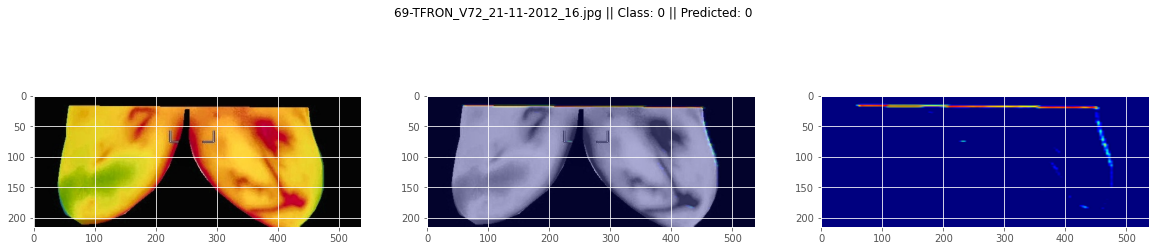

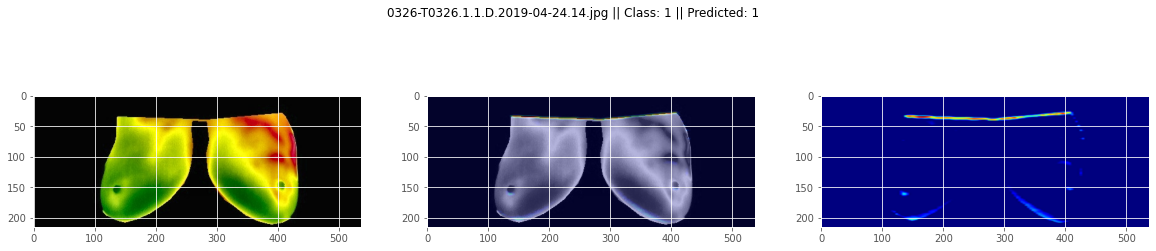

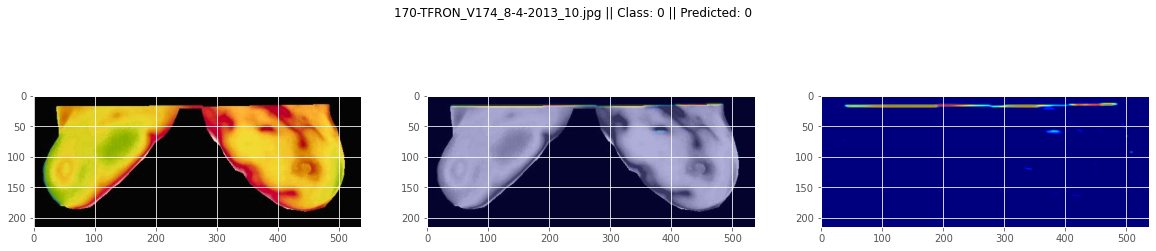

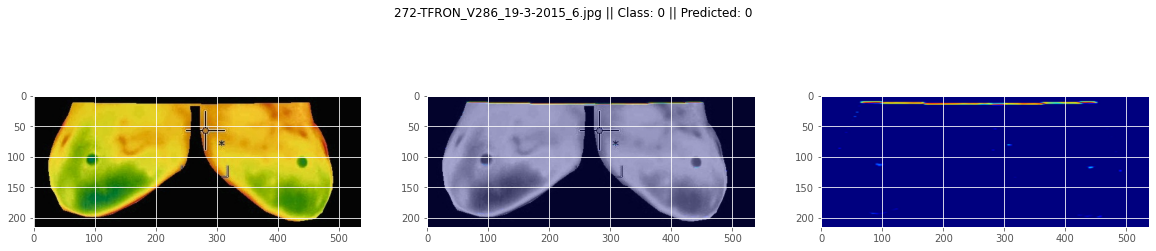

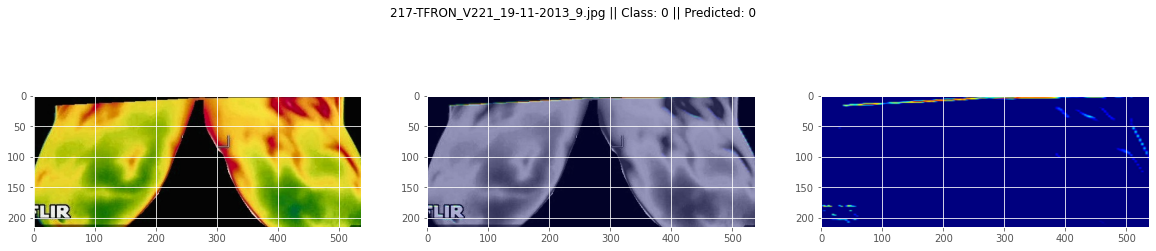

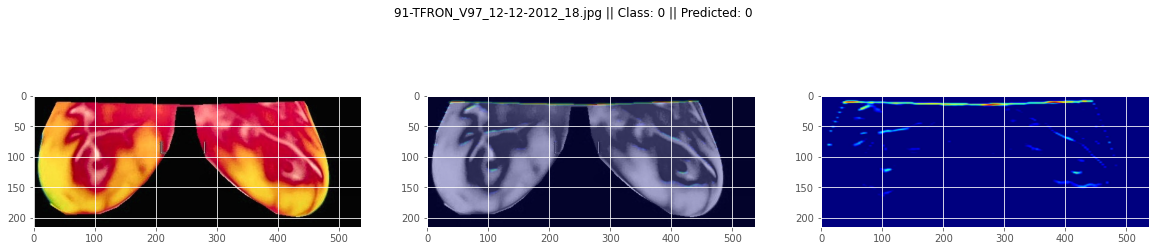

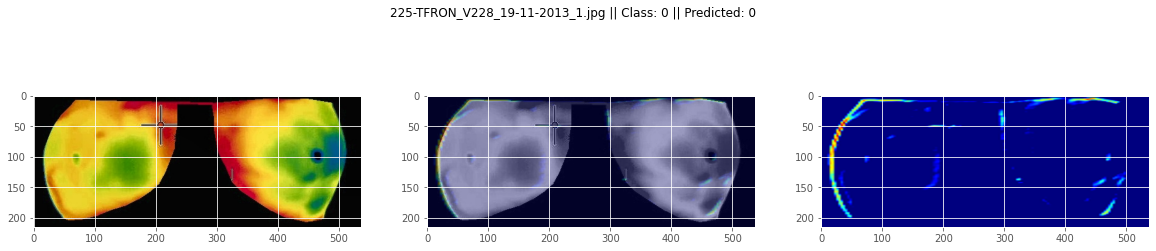

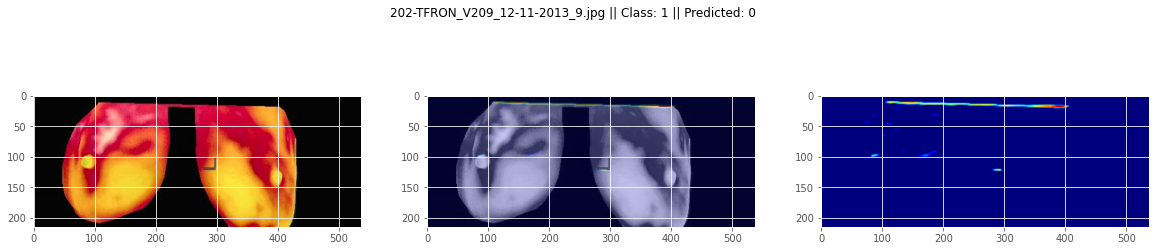

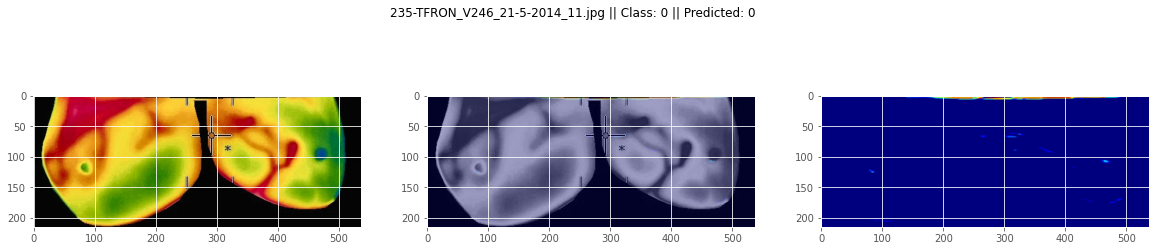

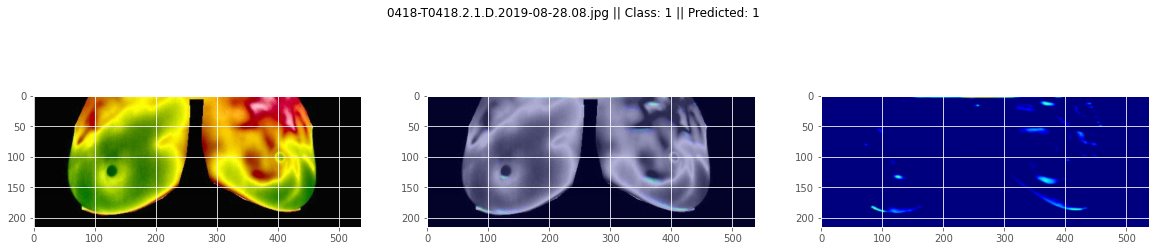

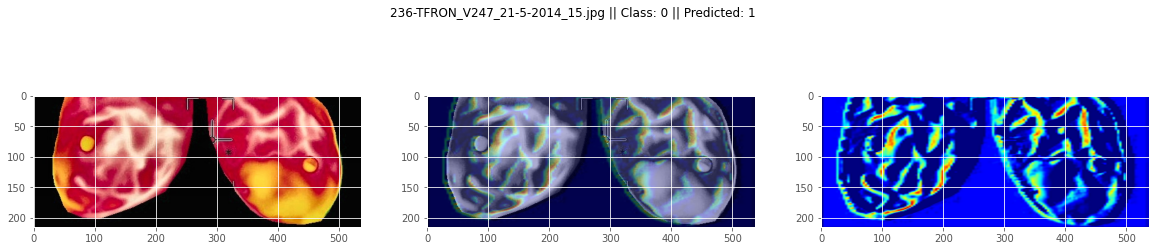

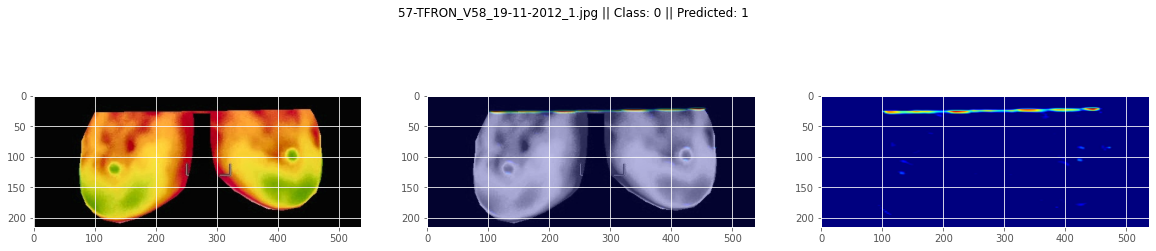

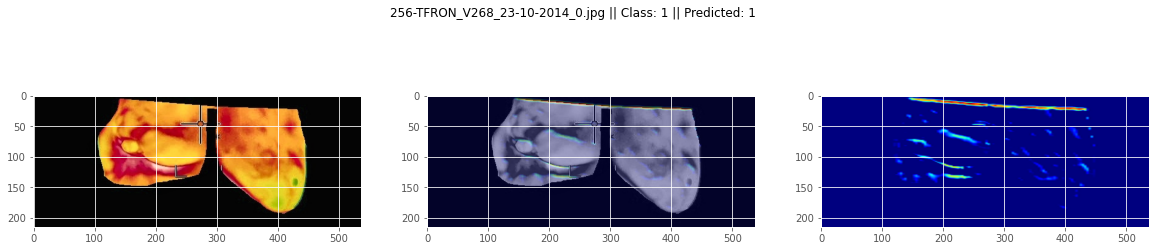

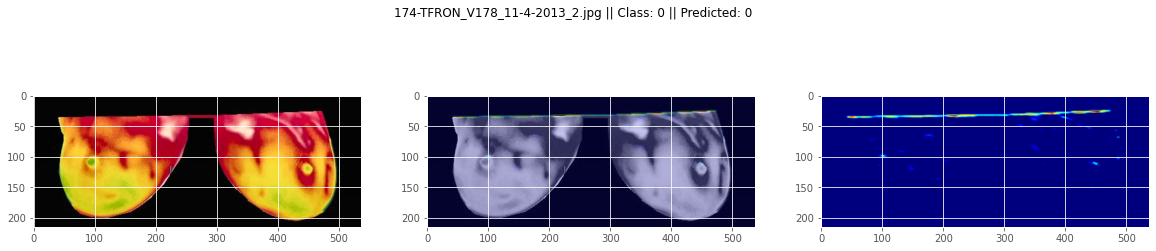

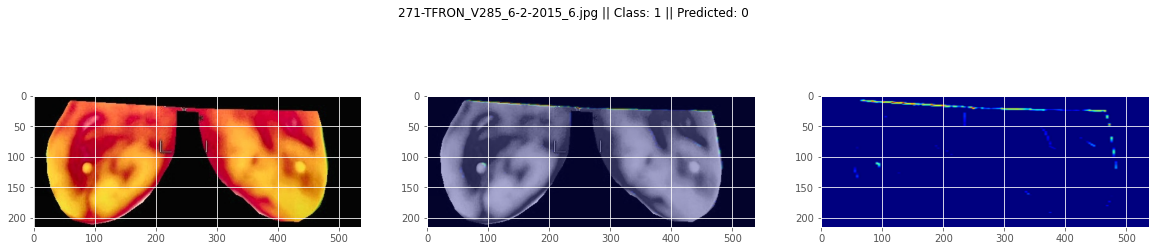

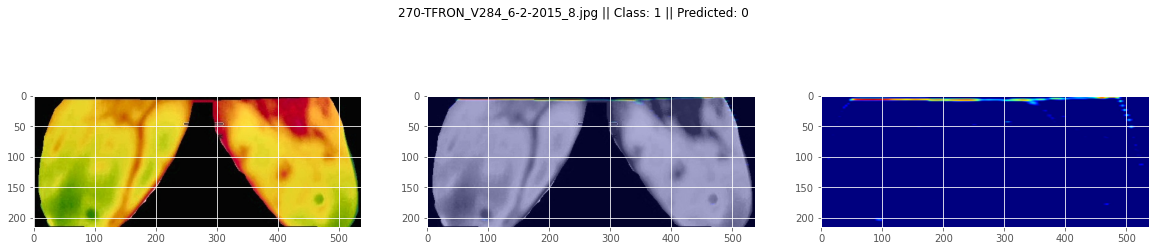

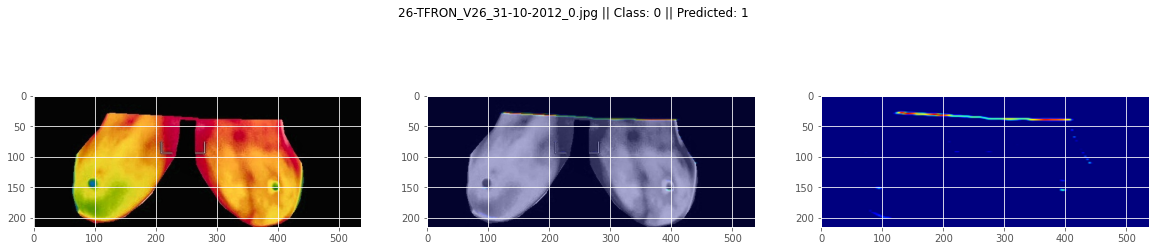

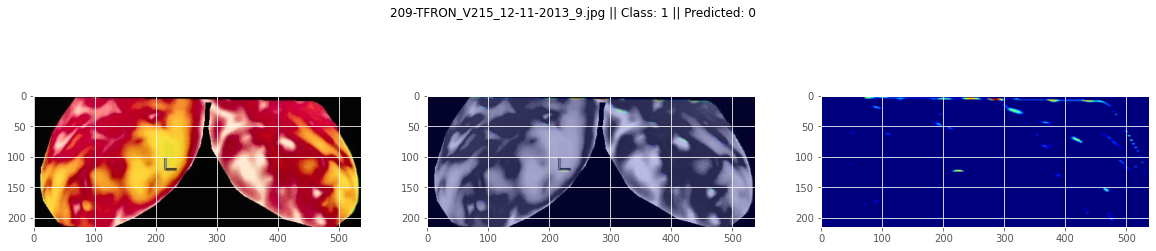

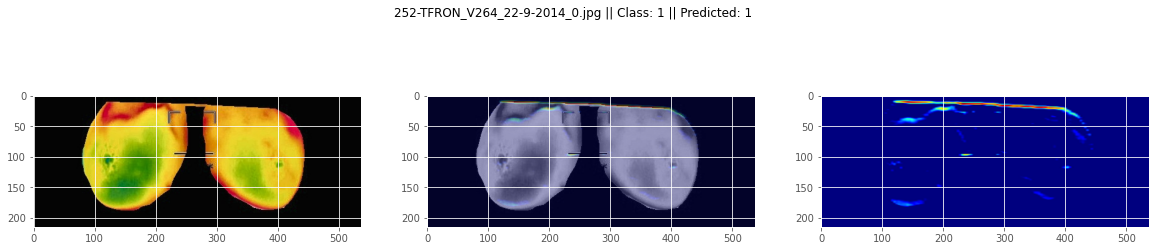

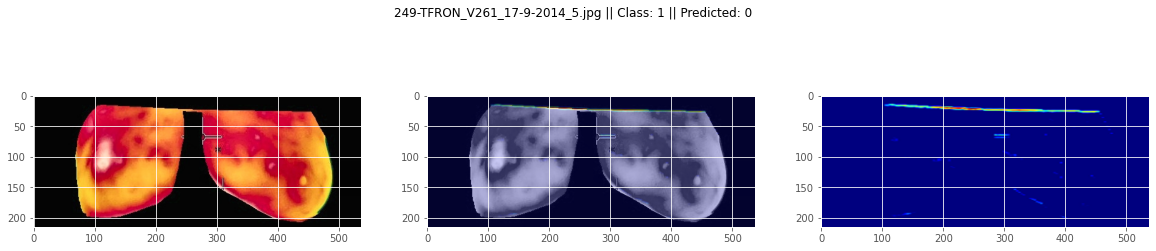

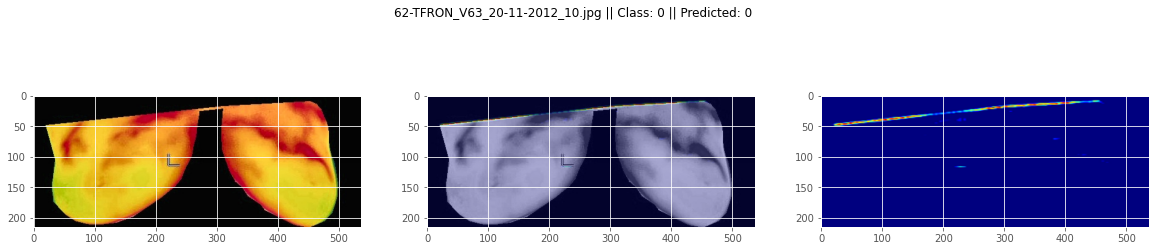

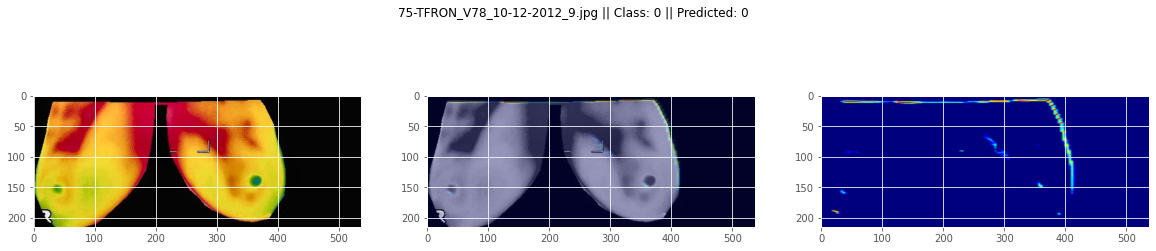

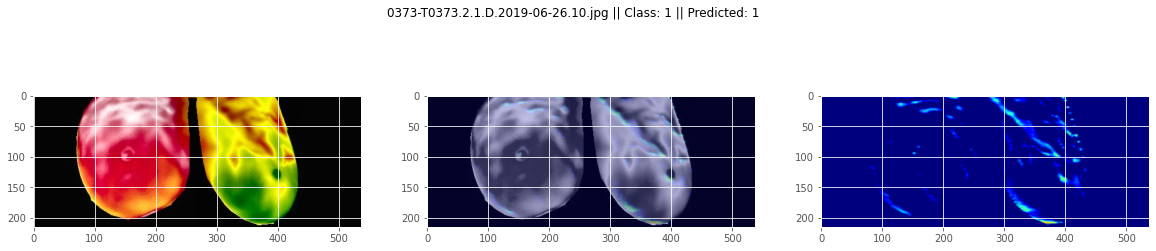

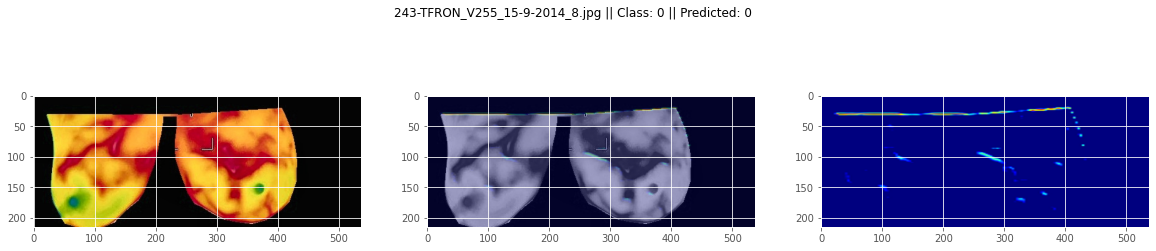

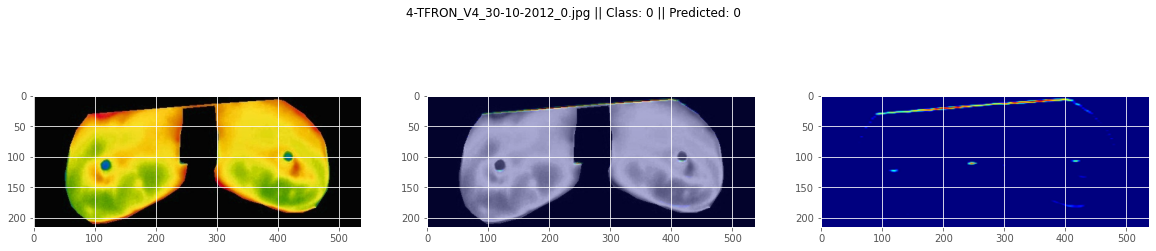

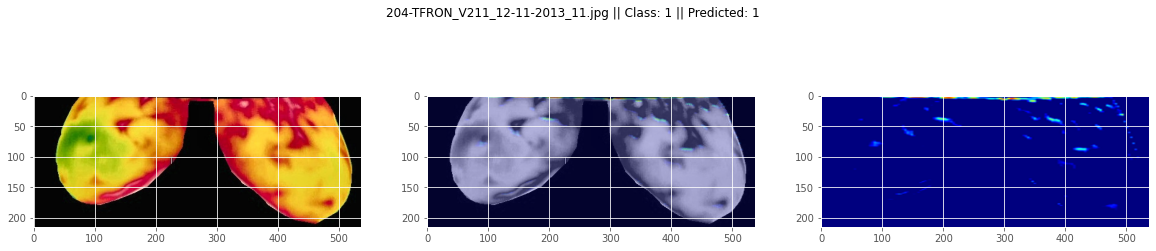

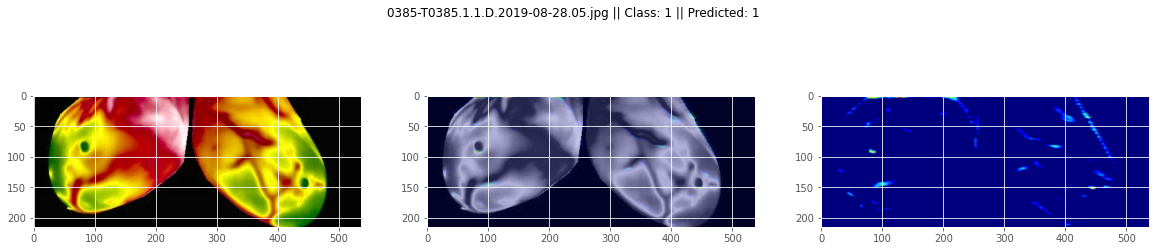

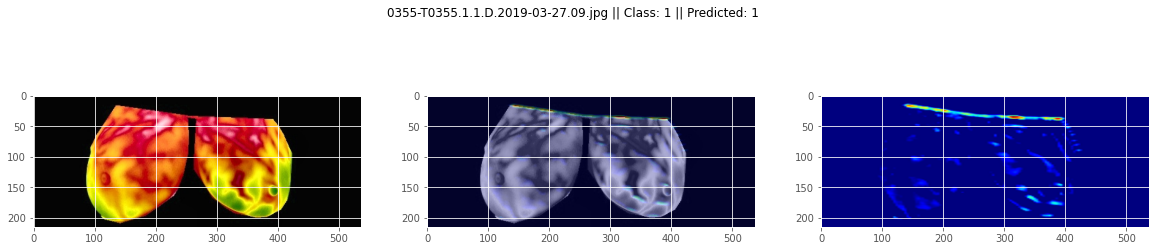

In [27]:
for index, test_image in data.test.iterrows():
	img = cv.cvtColor(cv.imread(test_image.filename), cv.COLOR_BGR2RGB)
	img = cv.resize(img, (parameters.width, parameters.height))
	img = img.astype("float32") * 1./255
	img = np.expand_dims(img, axis=0)

	predicted = np.argmax(model.predict(img)[0])

	heatmap = get_gradcam_heatmap(img, model, predicted)
	title = os.path.basename(test_image.filename) + " || " + "Class: " + test_image.category + " || " + "Predicted: " + str(predicted)

	save_gradcam(test_image.filename, heatmap, title)